Image-Based Project:

Members:
<br>Kai Miller (kdm220002)
<br>Benjamin Walmer (bjw220002)

Using RealWaste Dataset:

Dataset research paper link: https://www.mdpi.com/2078-2489/14/12/633

Citation:<br>
Single, S.; Iranmanesh, S.; Raad, R. RealWaste: A Novel Real-Life Data Set for Landfill Waste Classification Using Deep Learning. Information 2023, 14, 633. https://doi.org/10.3390/info14120633

Research Paper Code link: https://github.com/sam-single/realwaste/blob/main/realwaste-research.ipynb

Imports:

In [ ]:
!pip install gdown Augmentor

In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import gdown
from os import listdir
from shutil import copy
from time import sleep
from PIL import Image
from tensorflow.image import resize
from tensorflow.io import decode_jpeg, encode_jpeg, write_file
from tensorflow.dtypes import saturate_cast
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE as autotune
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import cast
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
SEED = 723
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Reading in Dataset from Public Google Drive Link:

In [ ]:
url = "https://drive.google.com/uc?id=1PxnyVJVuFUmrLCKgjhiZwke6iTAEPXbJ"
output = "realwaste.zip"
if not os.path.exists("realwaste"):
    gdown.download(url, output, quiet=False)
    !unzip -q realwaste.zip -d realwaste
else:
    print("Dataset already exists, skipping download.")


Downloading...
From (original): https://drive.google.com/uc?id=1PxnyVJVuFUmrLCKgjhiZwke6iTAEPXbJ
From (redirected): https://drive.google.com/uc?id=1PxnyVJVuFUmrLCKgjhiZwke6iTAEPXbJ&confirm=t&uuid=3f51c5d7-0e57-489e-9251-e67b4ffd322a
To: /content/realwaste.zip
100%|██████████| 689M/689M [00:05<00:00, 126MB/s]


In [ ]:
real_waste_original_path = '/content/realwaste/realwaste-main/RealWaste/'
# RealWaste training, validation, and test paths
real_waste_training_path = '/content/realwaste_training/'
real_waste_validation_path = '/content/realwaste_validation/'
test_path = '/content/realwaste_test/'

# Create directories
labels = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Paper', 'Plastic',
          'Miscellaneous Trash', 'Textile Trash', 'Vegetation']
for label in labels:
    os.makedirs(real_waste_training_path + label, exist_ok=True)
    os.makedirs(real_waste_validation_path + label, exist_ok=True)
    os.makedirs(test_path + label, exist_ok=True)

# Processed image dimensions
img_height = 224  # Changed to 224 for MobileNetV2 efficiency
img_width = 224

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

# Enhanced hyperparameter configurations with CNN architecture tuning
hyperparameter_configs = [
    # Format: (batch_size, img_size, learn_rate_fc, learn_rate_fe, split_layer,
    #          cnn_layers, activation, dropout_rate, use_batch_norm)

    # Baseline configurations
    (32, 224, 1e-4, 1e-5, 100, [64, 32], 'relu', 0.3, True),
    (32, 224, 1e-4, 1e-5, 100, [128, 64, 32], 'relu', 0.3, True),

    # Testing different layer sizes
    (32, 224, 1e-4, 1e-5, 100, [256, 128], 'relu', 0.3, True),
    (32, 224, 1e-4, 1e-5, 100, [64], 'relu', 0.3, True),

    # Testing different activation functions
    (32, 224, 1e-4, 1e-5, 100, [128, 64], 'elu', 0.3, True),
    (32, 224, 1e-4, 1e-5, 100, [128, 64], 'leaky_relu', 0.3, True),

    # Testing different dropout rates
    (32, 224, 1e-4, 1e-5, 100, [128, 64], 'relu', 0.5, True),
    (32, 224, 1e-4, 1e-5, 100, [128, 64], 'relu', 0.2, True),

    # Testing without batch normalization
    (32, 224, 1e-4, 1e-5, 100, [128, 64], 'relu', 0.3, False),

    # Testing different batch sizes with optimal architecture
    (16, 224, 1e-4, 1e-5, 100, [128, 64], 'relu', 0.3, True),
    (64, 224, 1e-4, 1e-5, 100, [128, 64], 'relu', 0.3, True),
]

batch_size = 32

all_param_results = []
all_histories = []

Exploratory Analysis:

In [ ]:
def count_images(path):
    """Count images in directory"""
    directory = listdir(path)
    return len(directory)

In [ ]:
def split_dataset(input_path, train_path, val_path, test_path, val_prop, test_prop, label):
    """Split datasets into training, validation and testing"""
    num_files = count_images(input_path + label)
    file_names = listdir(input_path + label)

    # Calculate number of validation and testing images
    num_val = round(num_files * val_prop)
    num_test = round(num_files * test_prop)

    # Initialize empty lists for image indexes
    val_list = []
    test_list = []

    # Randomly assign file indexes for validation dataset
    i = 0
    while i < num_val:
        r = random.randint(0, num_files - 1)
        if r not in val_list:
            val_list.append(r)
            i += 1

    # Move validation dataset files
    name_incrementer = 1
    for j in val_list:
        copy(input_path + label + '/' + file_names[j],
             val_path + label + '/' + label + '_' + str(name_incrementer) + '.jpg')
        name_incrementer += 1

    # Randomly assign file indexes for testing dataset
    i = 0
    while i < num_test:
        r = random.randint(0, num_files - 1)
        if r not in test_list and r not in val_list:
            test_list.append(r)
            i += 1

    # Move test dataset files
    name_incrementer = 1
    for j in test_list:
        copy(input_path + label + '/' + file_names[j],
             test_path + label + '/' + label + '_' + str(name_incrementer) + '.jpg')
        name_incrementer += 1

    # Move remaining files into training dataset
    name_incrementer = 1
    for i in range(num_files):
        if i not in val_list and i not in test_list:
            copy(input_path + label + '/' + file_names[i],
                 train_path + label + '/' + label + '_' + str(name_incrementer) + '.jpg')
            name_incrementer += 1

In [ ]:
def resize_image(path, width, height):
    """Resize images"""
    directory = listdir(path)
    for file in directory:
        try:
            image = open(path + '/' + file, 'rb')
            binary_representation = image.read()
            decoded_representation = decode_jpeg(binary_representation)
            resized_image = resize(decoded_representation, [width, height])
            resized_image = saturate_cast(resized_image, 'uint8')
            encoded_image = encode_jpeg(resized_image)
            write_file(path + '/' + file, encoded_image)
        except Exception as e:
            print(f"Error processing {file}: {e}")

In [ ]:
def convert_rgb_images(path):
    """Check images for RGB mode and convert if required"""
    directory = listdir(path)
    for file in directory:
        try:
            img = Image.open(path + '/' + file)
            if img.mode != 'RGB':
                img.convert('RGB').save(path + '/' + file)
        except Exception as e:
            print(f"Error converting {file}: {e}")

Splitting RealWaste Dataset

In [ ]:
for label in labels:
    split_dataset(real_waste_original_path, real_waste_training_path,
                  real_waste_validation_path, test_path, 0.2, 0.1, label)

# Print file counts
for label in labels:
    print(f'{label}:')
    print(f'  Training: {count_images(real_waste_training_path + label)}')
    print(f'  Validation: {count_images(real_waste_validation_path + label)}')
    print(f'  Test: {count_images(test_path + label)}\n')

Cardboard:
  Training: 323
  Validation: 92
  Test: 46

Food Organics:
  Training: 288
  Validation: 82
  Test: 41

Glass:
  Training: 294
  Validation: 84
  Test: 42

Metal:
  Training: 553
  Validation: 158
  Test: 79

Paper:
  Training: 350
  Validation: 100
  Test: 50

Plastic:
  Training: 645
  Validation: 184
  Test: 92

Miscellaneous Trash:
  Training: 346
  Validation: 99
  Test: 50

Textile Trash:
  Training: 222
  Validation: 64
  Test: 32

Vegetation:
  Training: 305
  Validation: 87
  Test: 44



Preprocessing

In [ ]:
for label in labels:
    print(f'Processing {label}...')
    # Training
    convert_rgb_images(real_waste_training_path + label)
    resize_image(real_waste_training_path + label, img_width, img_height)
    # Validation
    convert_rgb_images(real_waste_validation_path + label)
    resize_image(real_waste_validation_path + label, img_width, img_height)
    # Test
    convert_rgb_images(test_path + label)
    resize_image(test_path + label, img_width, img_height)
    print(f'{label} complete\n')

Processing Cardboard...
Cardboard complete

Processing Food Organics...
Food Organics complete

Processing Glass...
Glass complete

Processing Metal...
Metal complete

Processing Paper...
Paper complete

Processing Plastic...
Plastic complete

Processing Miscellaneous Trash...
Miscellaneous Trash complete

Processing Textile Trash...
Textile Trash complete

Processing Vegetation...
Vegetation complete



Function to build CNN head

Hyperparameter Tuning:

In [ ]:
def process(image, label):
    """RGB normalization"""
    image = cast(image / 255.0, 'float32')
    return image, label

In [ ]:
train_ds = image_dataset_from_directory(
    real_waste_training_path,
    seed=SEED,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)
train_ds = train_ds.map(process).cache().prefetch(buffer_size=autotune)

Found 3326 files belonging to 9 classes.


In [ ]:
val_ds = image_dataset_from_directory(
    real_waste_validation_path,
    seed=SEED,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = val_ds.map(process).cache().prefetch(buffer_size=autotune)

Found 950 files belonging to 9 classes.


In [ ]:
test_ds = image_dataset_from_directory(
    test_path,
    seed=SEED,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)
test_ds = test_ds.map(process).cache().prefetch(buffer_size=autotune)

Found 476 files belonging to 9 classes.


MobileNetV2

In [ ]:
def build_cnn_head(base_model_output, cnn_layers, activation='relu',
                   dropout_rate=0.3, use_batch_norm=True, num_classes=9):
    """
    Build a configurable CNN head on top of base model

    Args:
        base_model_output: Output from base model (MobileNetV2)
        cnn_layers: List of filter sizes for conv layers, e.g., [128, 64, 32]
        activation: Activation function ('relu', 'elu', 'leaky_relu')
        dropout_rate: Dropout rate between layers
        use_batch_norm: Whether to use batch normalization
        num_classes: Number of output classes

    Returns:
        Output tensor
    """
    x = base_model_output

    # Add CNN layers
    for i, filters in enumerate(cnn_layers):
        # Convolutional layer
        x = Conv2D(filters, (3, 3), padding='same',
                   name=f'conv_{i+1}')(x)

        # Batch normalization
        if use_batch_norm:
            x = BatchNormalization(name=f'bn_{i+1}')(x)

        # Activation
        if activation == 'leaky_relu':
            x = tf.keras.layers.LeakyReLU(alpha=0.1, name=f'activation_{i+1}')(x)
        else:
            x = tf.keras.layers.Activation(activation, name=f'activation_{i+1}')(x)

        # Max pooling (only if spatial dimensions allow)
        if i < len(cnn_layers) - 1:  # Don't pool on last layer
            x = MaxPooling2D((2, 2), name=f'pool_{i+1}')(x)

        # Dropout
        if dropout_rate > 0:
            x = Dropout(dropout_rate, name=f'dropout_{i+1}')(x)

    # Global average pooling
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)

    # Final dropout before classification
    if dropout_rate > 0:
        x = Dropout(dropout_rate, name='dropout_final')(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    return outputs


In [ ]:
# Update the hyperparameter loop to extract CNN parameters:
for config_num, (batch_size, img_size, learn_rate_fc, learn_rate_fe, split_layer,
                 cnn_layers, activation, dropout_rate, use_batch_norm) in enumerate(hyperparameter_configs, 1):
    print(f'\n{"="*80}')
    print(f'CONFIGURATION {config_num}/{len(hyperparameter_configs)}')
    print(f'{"="*80}')
    print(f'Batch Size: {batch_size}')
    print(f'Image Size: {img_size}x{img_size}')
    print(f'FC Learning Rate: {learn_rate_fc}')
    print(f'Fine-Tune Learning Rate: {learn_rate_fe}')
    print(f'Split Layer: {split_layer}')
    print(f'CNN Layers: {cnn_layers}')
    print(f'Activation: {activation}')
    print(f'Dropout Rate: {dropout_rate}')
    print(f'Batch Normalization: {use_batch_norm}')
    print(f'{"="*80}\n')

    # Reset random seeds
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

    print(f'Building CNN architecture: {cnn_layers}')
    print(f'  Activation: {activation}')
    print(f'  Dropout: {dropout_rate}')
    print(f'  Batch Normalization: {use_batch_norm}')

    base_model = MobileNetV2(
      input_shape=(img_size, img_size, 3),
      include_top=False,
      weights='imagenet'
)
    base_model.trainable = False

# Build model with CNN head
    inputs = Input(shape=(img_size, img_size, 3))
    base_output = base_model(inputs)
    outputs = build_cnn_head(
    base_output,
    cnn_layers=cnn_layers,
    activation=activation,
    dropout_rate=dropout_rate,
    use_batch_norm=use_batch_norm,
    num_classes=9
)

    mobile_net_v2 = Model(inputs, outputs, name='MobileNetV2_CNN')

# Print model summary for first configuration
    if config_num == 1:
      print("\nModel Architecture Summary:")
      mobile_net_v2.summary()

    mobile_net_v2.compile(
    optimizer=Adam(learn_rate_fc),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min',
                               restore_best_weights=True)

    history_fc = mobile_net_v2.fit(
      train_ds,
      validation_data=val_ds,
      epochs=100,
      verbose=1,
      callbacks=[early_stopping]
)

    loss_fc, acc_fc, prec_fc, rec_fc = mobile_net_v2.evaluate(test_ds, verbose=0)

    all_param_results.append({
    'Config': config_num,
    'Stage': 'FC Training',
    'Batch Size': batch_size,
    'Image Size': img_size,
    'Learning Rate': learn_rate_fc,
    'Split Layer': split_layer,
    'CNN Layers': str(cnn_layers),
    'Activation': activation,
    'Dropout': dropout_rate,
    'Batch Norm': use_batch_norm,
    'Epochs Run': len(history_fc.history['loss']),
    'Final Train Acc': history_fc.history['accuracy'][-1],
    'Final Val Acc': history_fc.history['val_accuracy'][-1],
    'Best Val Acc': max(history_fc.history['val_accuracy']),
    'Test Accuracy': acc_fc,
    'Test Precision': prec_fc,
    'Test Recall': rec_fc
})


CONFIGURATION 1/11
Batch Size: 32
Image Size: 224x224
FC Learning Rate: 0.0001
Fine-Tune Learning Rate: 1e-05
Split Layer: 100
CNN Layers: [64, 32]
Activation: relu
Dropout Rate: 0.3
Batch Normalization: True

Building CNN architecture: [64, 32]
  Activation: relu
  Dropout: 0.3
  Batch Normalization: True
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model Architecture Summary:


Model: "MobileNetV2_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 7, 7, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 3, 3, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 3, 3, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,014,473 (11.50 MB)

 Trainable params: 756,297 (2.89 MB)

 Non-trainable params: 2,258,176 (8.61 MB)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 74s 446ms/step - accuracy: 0.2706 - loss: 1.9912 - precision: 0.6397 - recall: 0.0390 - val_accuracy: 0.5747 - val_loss: 1.2409 - val_precision: 0.7986 - val_recall: 0.3547
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5761 - loss: 1.3513 - precision: 0.8413 - recall: 0.2262 - val_accuracy: 0.6484 - val_loss: 1.0932 - val_precision: 0.8640 - val_recall: 0.4147
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6781 - loss: 1.1197 - precision: 0.8908 - recall: 0.3339 - val_accuracy: 0.6895 - val_loss: 1.0010 - val_precision: 0.8804 - val_recall: 0.4495
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7291 - loss: 0.9959 - precision: 0.9093 - recall: 0.4068 - val_accuracy: 0.7253 - val_loss: 0.9312 - val_precision: 0.8895 - val_recall: 0.4916
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7852 - loss: 0.8655 - precision: 0.9330 - recall: 0.4892 - val_accuracy: 0.7463 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 172ms/step - accuracy: 0.3770 - loss: 1.7736 - precision_5: 0.7604 - recall_5: 0.1227 - val_accuracy: 0.6400 - val_loss: 1.0642 - val_precision_5: 0.7922 - val_recall_5: 0.5137
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6940 - loss: 1.0015 - precision_5: 0.8720 - recall_5: 0.4594 - val_accuracy: 0.7105 - val_loss: 0.8716 - val_precision_5: 0.8392 - val_recall_5: 0.5821
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7814 - loss: 0.7728 - precision_5: 0.9025 - recall_5: 0.5947 - val_accuracy: 0.7347 - val_loss: 0.7993 - val_precision_5: 0.8635 - val_recall_5: 0.6126
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8322 - loss: 0.6207 - precision_5: 0.9232 - recall_5: 0.6791 - val_accuracy: 0.7411 - val_loss: 0.7479 - val_precision_5: 0.8492 - val_recall_5: 0.6400
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8847 - loss: 0.4893 - precision_5: 0.9461 - recall_5: 0.7677 -

Output Graphs:

In [ ]:
params_df = pd.DataFrame(all_param_results)
params_df

Config        Stage  Batch Size  Image Size  Learning Rate  Split Layer  \
0        1  FC Training          32         224         0.0001          100   
1        2  FC Training          32         224         0.0001          100   
2        3  FC Training          32         224         0.0001          100   
3        4  FC Training          32         224         0.0001          100   
4        5  FC Training          32         224         0.0001          100   
5        6  FC Training          32         224         0.0001          100   
6        7  FC Training          32         224         0.0001          100   
7        8  FC Training          32         224         0.0001          100   
8        9  FC Training          32         224         0.0001          100   
9       10  FC Training          16         224         0.0001          100   
10      11  FC Training          64         224         0.0001          100   

       CNN Layers  Activation  Dropout  Batch Norm  Epochs Run  \
0        [64, 32]        relu      0.3        True          30   
1   [128, 64, 32]        relu      0.3        True          43   
2      [256, 128]        relu      0.3        True          18   
3            [64]        relu      0.3        True          34   
4       [128, 64]         elu      0.3        True          17   
5       [128, 64]  leaky_relu      0.3        True          22   
6       [128, 64]        relu      0.5        True          29   
7       [128, 64]        relu      0.2        True          29   
8       [128, 64]        relu      0.3       False          17   
9       [128, 64]        relu      0.3        True          29   
10      [128, 64]        relu      0.3        True          29   

    Final Train Acc  Final Val Acc  Best Val Acc  Test Accuracy  \
0          0.995189       0.791579      0.802105       0.785714   
1          0.953097       0.792632      0.801053       0.810924   
2          1.000000       0.807368      0.807368       0.802521   
3          0.994889       0.774737      0.785263       0.810924   
4          0.999399       0.777895      0.777895       0.792017   
5          0.999699       0.797895      0.797895       0.796219   
6          0.991281       0.777895      0.800000       0.802521   
7          1.000000       0.793684      0.801053       0.800420   
8          0.988876       0.793684      0.793684       0.800420   
9          0.999699       0.786316      0.798947       0.800420   
10         0.999699       0.783158      0.796842       0.794118   

    Test Precision  Test Recall  
0         0.863184     0.728992  
1         0.866337     0.735294  
2         0.837529     0.768908  
3         0.855107     0.756303  
4         0.844125     0.739496  
5         0.847087     0.733193  
6         0.861985     0.747899  
7         0.847575     0.771008  
8         0.830664     0.762605  
9         0.852459     0.764706  
10        0.843458     0.758403

In [ ]:
# History Plots
print('\nGenerating Training History Plots\n')

# Get the best configuration
best_config = params_df[params_df['Stage'] == 'FC Training'].nlargest(1, 'Test Accuracy').iloc[0]
best_config_num = int(best_config['Config'])

print(f'Creating plots for best configuration #{best_config_num}')
print(f'  CNN Layers: {best_config["CNN Layers"]}')
print(f'  Activation: {best_config["Activation"]}')
print(f'  Dropout: {best_config["Dropout"]}')
print(f'  Batch Normalization: {best_config["Batch Norm"]}')
print(f'  Test Accuracy: {best_config["Test Accuracy"]:.4f}\n')


Generating Training History Plots

Creating plots for best configuration #2
  CNN Layers: [128, 64, 32]
  Activation: relu
  Dropout: 0.3
  Batch Normalization: True
  Test Accuracy: 0.8109



In [ ]:
# Extract best hyperparameters
best_batch_size = int(best_config['Batch Size'])
best_img_size = int(best_config['Image Size'])
best_lr_fc = best_config['Learning Rate']
best_cnn_layers = eval(best_config['CNN Layers'])  # Convert string back to list
best_activation = best_config['Activation']
best_dropout = best_config['Dropout']
best_batch_norm = best_config['Batch Norm']

print(f'Retraining best model for visualization...\n')

# Reset random seeds
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Build best model
base_model_best = MobileNetV2(
    input_shape=(best_img_size, best_img_size, 3),
    include_top=False,
    weights='imagenet'
)
base_model_best.trainable = False

inputs_best = Input(shape=(best_img_size, best_img_size, 3))
base_output_best = base_model_best(inputs_best)
outputs_best = build_cnn_head(
    base_output_best,
    cnn_layers=best_cnn_layers,
    activation=best_activation,
    dropout_rate=best_dropout,
    use_batch_norm=best_batch_norm,
    num_classes=9
)

best_model = Model(inputs_best, outputs_best, name='Best_MobileNetV2_CNN')

# Compile and train
best_model.compile(
    optimizer=Adam(best_lr_fc),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate on test set
test_loss, test_acc, test_prec, test_rec = best_model.evaluate(test_ds, verbose=0)

print(f'\nBest Model Test Results:')
print(f'  Accuracy: {test_acc:.4f}')
print(f'  Precision: {test_prec:.4f}')
print(f'  Recall: {test_rec:.4f}\n')

Retraining best model for visualization...

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 185ms/step - accuracy: 0.1661 - loss: 2.4711 - precision_11: 0.2086 - recall_11: 0.0398 - val_accuracy: 0.5368 - val_loss: 1.6244 - val_precision_11: 1.0000 - val_recall_11: 0.0316
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3262 - loss: 1.8674 - precision_11: 0.5278 - recall_11: 0.1260 - val_accuracy: 0.6000 - val_loss: 1.3735 - val_precision_11: 0.9404 - val_recall_11: 0.1495
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4126 - loss: 1.6500 - precision_11: 0.6338 - recall_11: 0.1753 - val_accuracy: 0.6442 - val_loss: 1.2118 - val_precision_11: 0.9068 - val_recall_11: 0.2663
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4737 - loss: 1.4966 - precision_11: 0.7286 - recall_11: 0.2279 - val_accuracy: 0.6663 - val_loss: 1.1393 - val_precision_11: 0.9220 - val_recall_11: 0.3358
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - ac

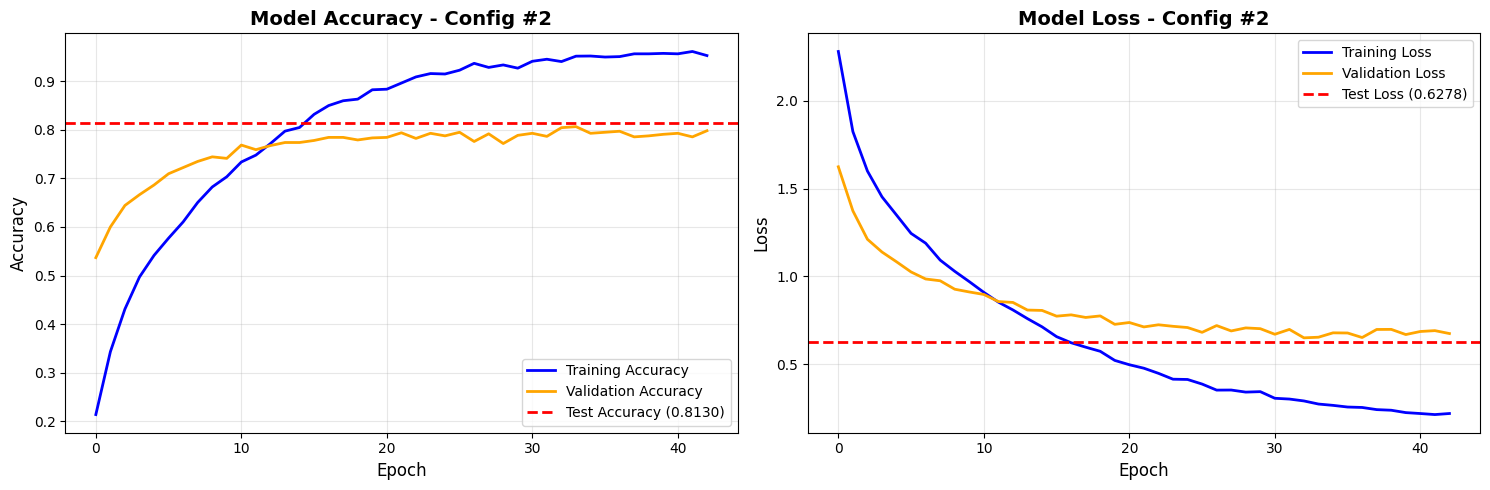

Training history plots saved as training_history.png



In [ ]:
# Create training history plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
axes[0].axhline(y=test_acc, color='red', linestyle='--', linewidth=2, label=f'Test Accuracy ({test_acc:.4f})')
axes[0].set_title(f'Model Accuracy - Config #{best_config_num}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[1].axhline(y=test_loss, color='red', linestyle='--', linewidth=2, label=f'Test Loss ({test_loss:.4f})')
axes[1].set_title(f'Model Loss - Config #{best_config_num}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print('Training history plots saved as training_history.png\n')

Generating Test Predictions



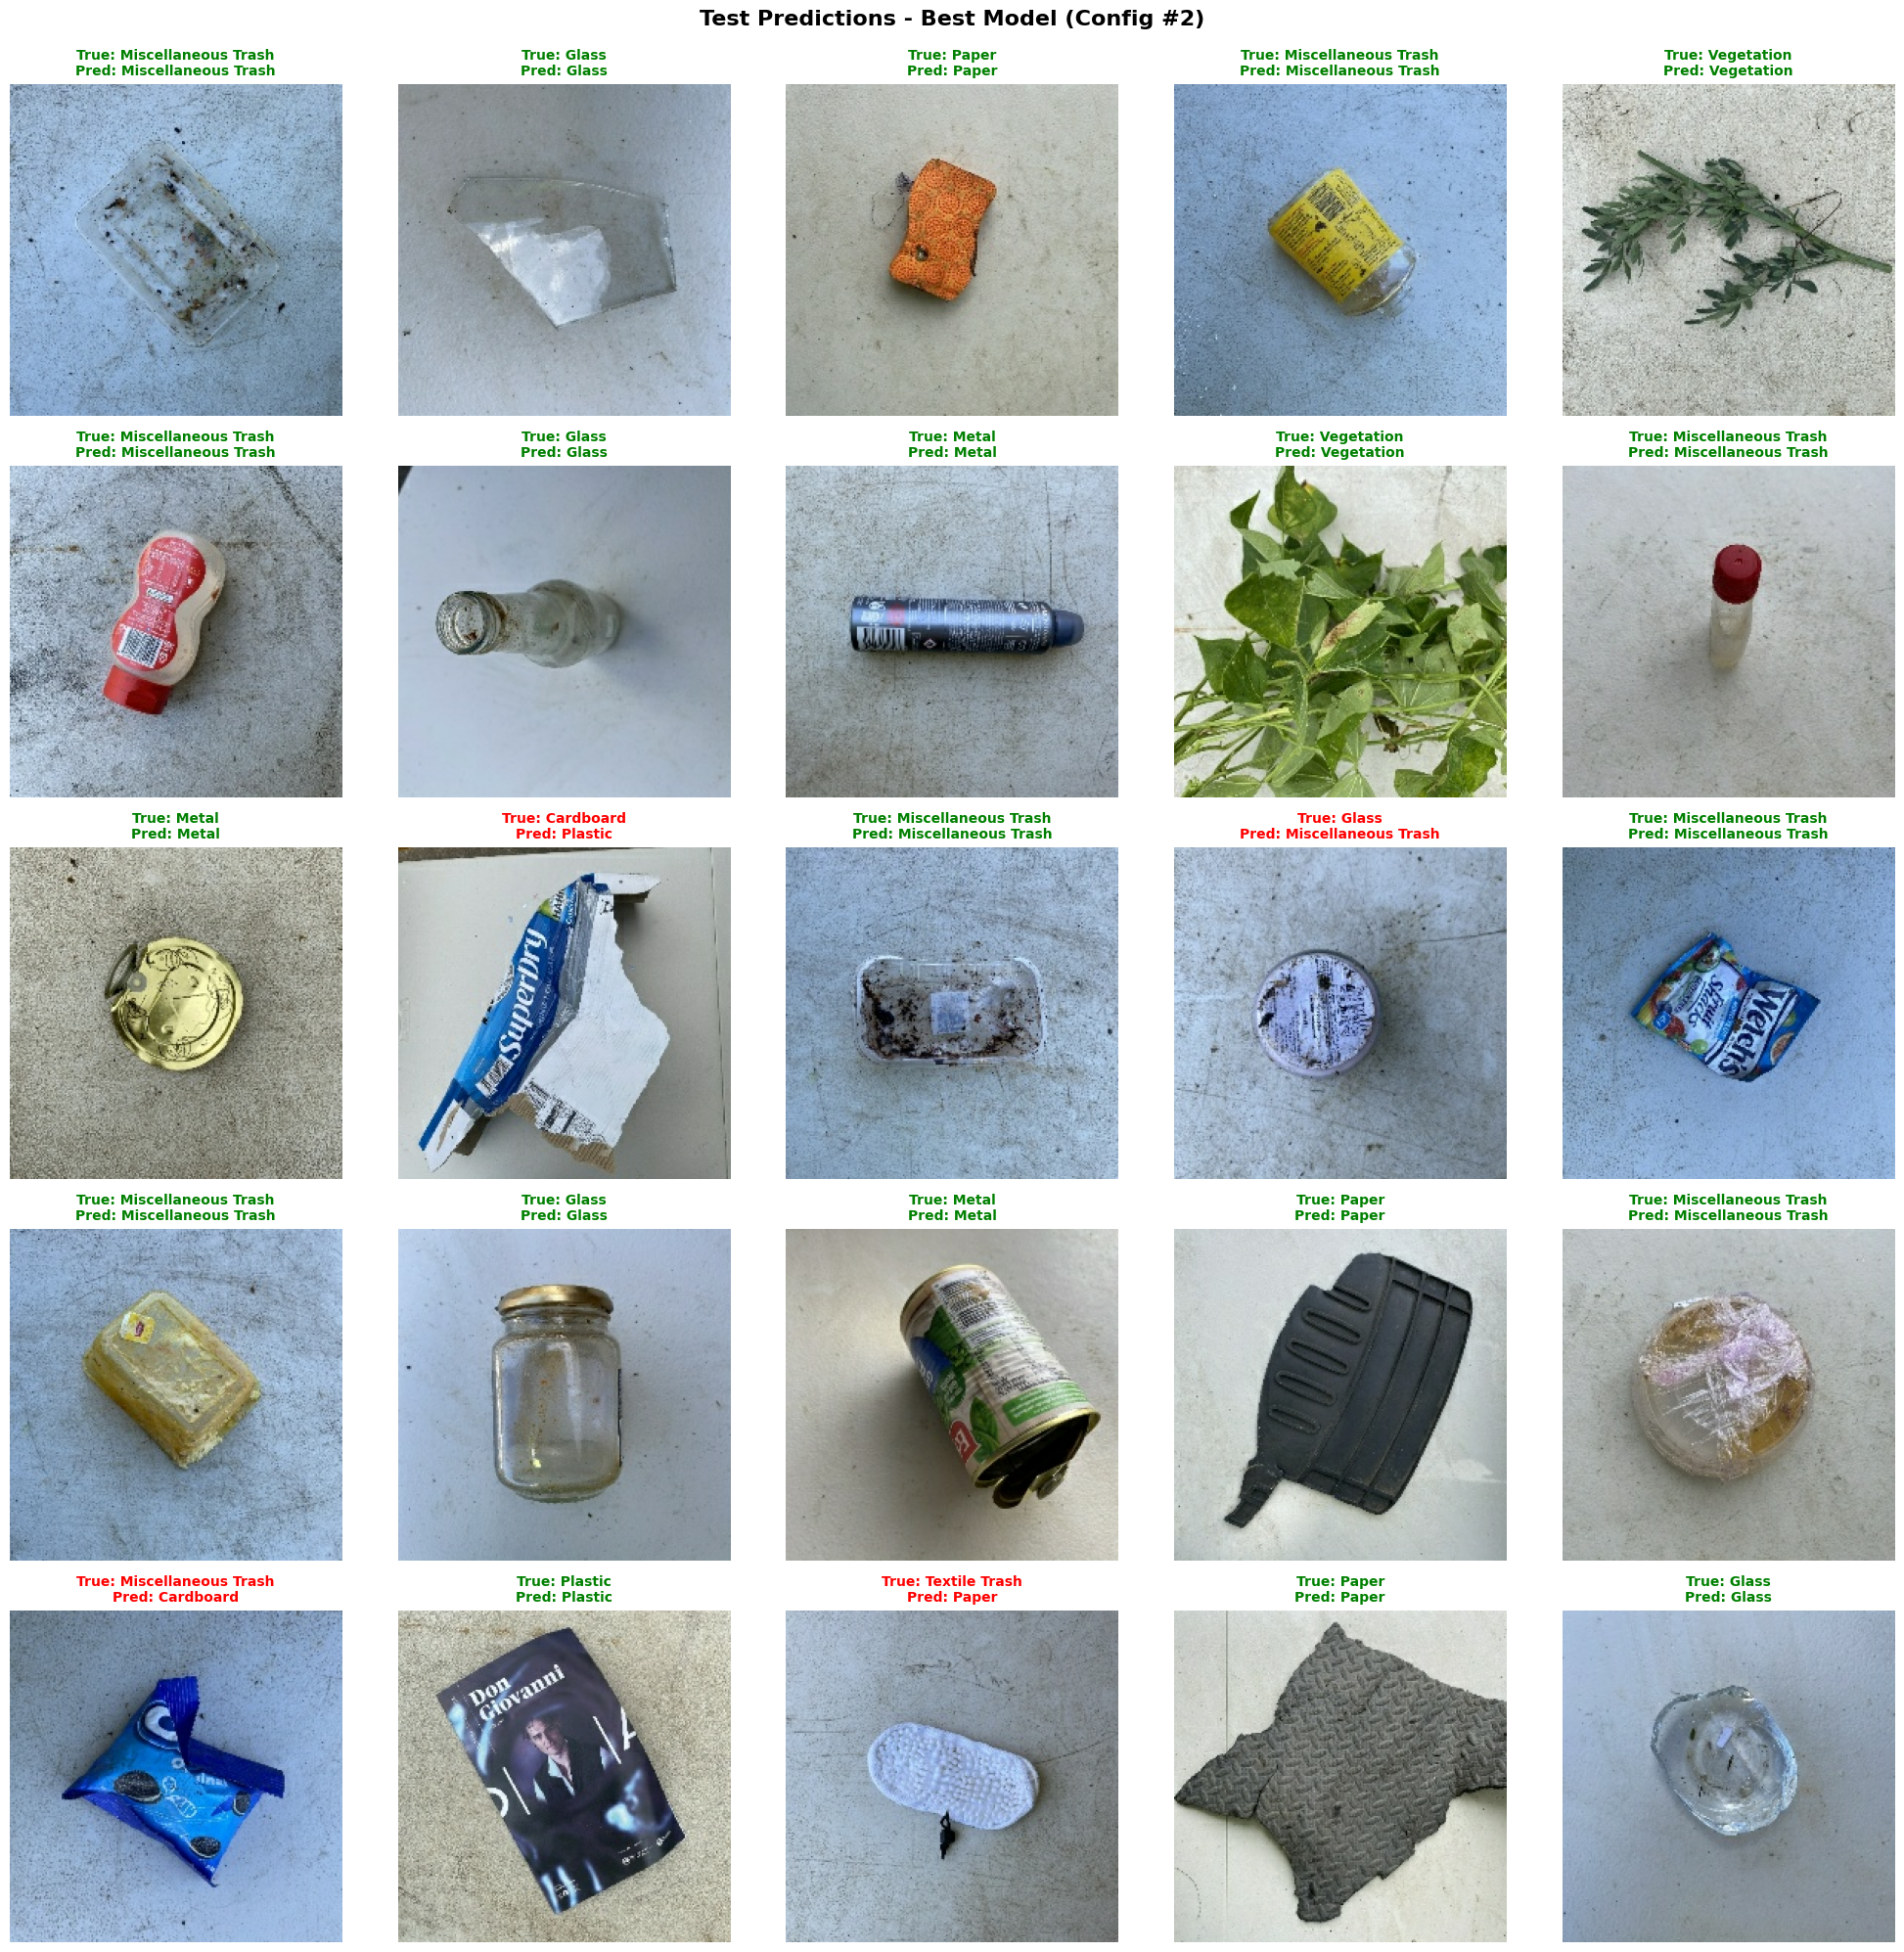

Test predictions visualization saved as test_predictions.png



In [ ]:
print('Generating Test Predictions\n')

# Get 25 test samples with predictions
class_names = labels

# Collect test samples
test_images = []
test_true_labels = []
test_pred_labels = []
test_correct = []

num_samples = 0
for images, labels_batch in test_ds:
    predictions = best_model.predict(images, verbose=0)

    for i in range(len(images)):
        if num_samples >= 25:
            break

        test_images.append(images[i].numpy())
        true_label = class_names[np.argmax(labels_batch[i])]
        pred_label = class_names[np.argmax(predictions[i])]

        test_true_labels.append(true_label)
        test_pred_labels.append(pred_label)
        test_correct.append(true_label == pred_label)

        num_samples += 1

    if num_samples >= 25:
        break

# Create visualization of test predictions
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.ravel()

for i in range(25):
    axes[i].imshow(test_images[i])

    # Color code: green for correct, red for incorrect
    color = 'green' if test_correct[i] else 'red'

    axes[i].set_title(
        f'True: {test_true_labels[i]}\nPred: {test_pred_labels[i]}',
        fontsize=10,
        color=color,
        fontweight='bold'
    )
    axes[i].axis('off')

plt.suptitle(f'Test Predictions - Best Model (Config #{best_config_num})',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('test_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print('Test predictions visualization saved as test_predictions.png\n')

In [ ]:
print('Detailed Test Predictions\n')

predictions_df = pd.DataFrame({
    'Sample': range(1, 26),
    'True Label': test_true_labels,
    'Predicted Label': test_pred_labels,
    'Correct': ['✓' if c else '✗' for c in test_correct]
})

print(predictions_df.to_string(index=False))
print(f'\nAccuracy on these 25 samples: {sum(test_correct) / 25:.2%}')
print(f'Correct predictions: {sum(test_correct)}/25')
print(f'Incorrect predictions: {25 - sum(test_correct)}/25\n')

# Save predictions to CSV
predictions_df.to_csv('test_predictions.csv', index=False)
print('Test predictions saved as test_predictions.csv\n')

Detailed Test Predictions

 Sample          True Label     Predicted Label Correct
      1 Miscellaneous Trash Miscellaneous Trash       ✓
      2               Glass               Glass       ✓
      3               Paper               Paper       ✓
      4 Miscellaneous Trash Miscellaneous Trash       ✓
      5          Vegetation          Vegetation       ✓
      6 Miscellaneous Trash Miscellaneous Trash       ✓
      7               Glass               Glass       ✓
      8               Metal               Metal       ✓
      9          Vegetation          Vegetation       ✓
     10 Miscellaneous Trash Miscellaneous Trash       ✓
     11               Metal               Metal       ✓
     12           Cardboard             Plastic       ✗
     13 Miscellaneous Trash Miscellaneous Trash       ✓
     14               Glass Miscellaneous Trash       ✗
     15 Miscellaneous Trash Miscellaneous Trash       ✓
     16 Miscellaneous Trash Miscellaneous Trash       ✓
     17              

In [ ]:
print('\nVisualization Summary:')
print(f'\nGenerated Files:')
print(f'  1. training_history.png - Training/validation accuracy and loss curves')
print(f'  2. test_predictions.png - Visual grid of 25 test predictions')
print(f'  3. test_predictions.csv - Detailed predictions table')
print(f'  4. hyperparameter_results.csv - Complete hyperparameter tuning results')
print(f'\nBest Model Performance:')
print(f'  Configuration: #{best_config_num}')
print(f'  Test Accuracy: {test_acc:.4f}')
print(f'  Test Precision: {test_prec:.4f}')
print(f'  Test Recall: {test_rec:.4f}')



Visualization Summary:

Generated Files:
  1. training_history.png - Training/validation accuracy and loss curves
  2. test_predictions.png - Visual grid of 25 test predictions
  3. test_predictions.csv - Detailed predictions table
  4. hyperparameter_results.csv - Complete hyperparameter tuning results

Best Model Performance:
  Configuration: #2
  Test Accuracy: 0.8130
  Test Precision: 0.8778
  Test Recall: 0.7395
